In [16]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont
import requests
import copy
import torch
import base64
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [17]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

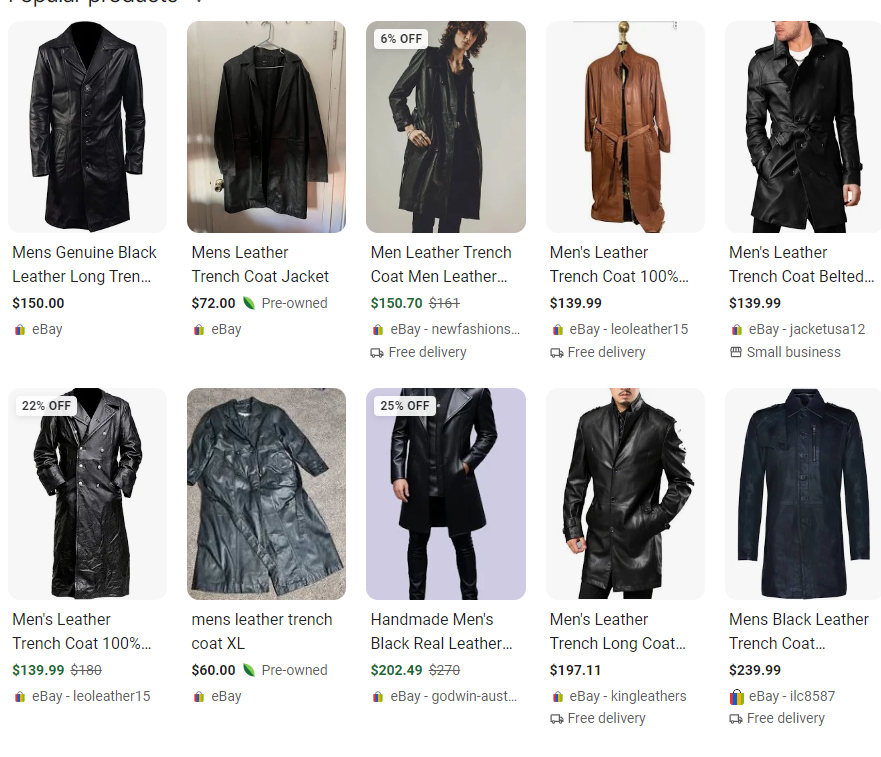

In [18]:
img_path = "content\Screenshot 2024-10-24 163750.png"
image = Image.open(img_path)
image = image.convert("RGB")
image

In [19]:
def run_example(image, task_prompt, text_input='', ):

    prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=1024,
        do_sample=False,
        num_beams=3,
        early_stopping=False,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [20]:
def draw_bbox(image, data):

    fig, ax = plt.subplots()
    ax.imshow(image)

    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    ax.axis('off')
    plt.show()



def draw_ocr_bboxes(image, prediction):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        if label.startswith('</s>'):
          label = label[4:]

        color = (238, 130, 238, 128)
        new_box = np.array(box).tolist()
        draw.polygon(new_box, width=3, outline=color)

        draw.text((new_box[0], new_box[1]+30),
                    "{}".format(label),
                    align="right",
                    fill='aqua')
    display(image)




def draw_polygons(image, prediction):

    overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    color = (238, 130, 238, 128)  # violet, semi-transparent
    outline_color = (*color[:3], 255)  # Full opacity for outline

    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        for polygon in polygons:
            polygon = np.array(polygon).flatten().tolist()
            if len(polygon) < 6:  # Less than 3 points
                continue

            draw.polygon(polygon, outline=outline_color, fill=color)
            draw.text((polygon[0] + 8, polygon[1] + 2), label, fill=outline_color)

    return Image.alpha_composite(image.convert('RGBA'), overlay)

In [21]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded


def convert_bbox_to_florence2(widget, image_path):
    """Convert widget bbox to Florence-2 format."""
    box = widget.bboxes[0]
    box = np.array([box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height']])

    w, h = Image.open(image_path).size
    box = (box / [w, h, w, h] * 1000).astype(int)

    return ''.join(f'<loc_{coord}>' for coord in box)


def convert_to_od_format(data):

    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

In [22]:
print (run_example(image, task_prompt='<CAPTION>'))

print (run_example(image, task_prompt='<DETAILED_CAPTION>'))

print (run_example(image, task_prompt='<MORE_DETAILED_CAPTION>'))

{'<CAPTION>': "A screen shot of a website with a variety of men's leather coats."}
{'<DETAILED_CAPTION>': 'The image shows a screenshot of a website with a variety of men\'s leather trench coats displayed on it. The text on the page reads "Men\'s Leather Trench Coat" and there are several images of the coats in different colors and styles.'}
{'<MORE_DETAILED_CAPTION>': "The image is a screenshot of a product page on a website. It shows a selection of men's leather trench coats in different colors and styles. The products are displayed on a white background and are arranged in a grid-like pattern. \n\nThere are six products in total, each with a unique design and price tag. The first product is a black leather trench coat with a long collar and long sleeves. The second product is an olive green trench coat, the third is a brown leather trench jacket, and the fourth is a navy blue trench coat. The fifth and sixth products are black leather jackets with long sleeves and a high collar. The

In [23]:
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(img_path)
display(widget)

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [25]:
box_str = convert_bbox_to_florence2(widget, img_path)

results = run_example(image, task_prompt='<REGION_TO_CATEGORY>', text_input=box_str)
print("Region category:", results)

results = run_example(image, task_prompt= '<REGION_TO_DESCRIPTION>', text_input=box_str)
print("Region description:", results)

Region category: {'<REGION_TO_CATEGORY>': 'person<loc_405><loc_501><loc_604><loc_947>'}
Region description: {'<REGION_TO_DESCRIPTION>': "men's black leather trench coat 25% off sale<loc_405><loc_501><loc_604><loc_947>"}


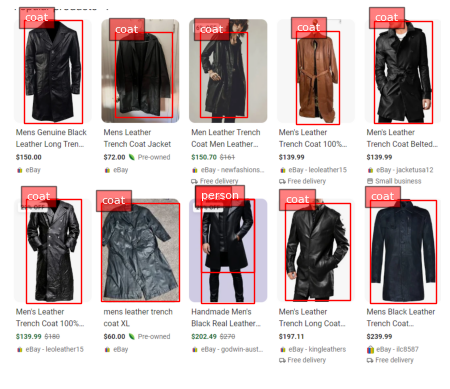

{'<OD>': {'bboxes': [[186.3314971923828, 397.0465087890625, 345.79248046875, 596.89453125], [737.8374633789062, 389.47650146484375, 872.6304931640625, 599.9225463867188], [562.5184936523438, 395.5325012207031, 696.4304809570312, 594.62353515625], [28.63249969482422, 21.574501037597656, 146.68649291992188, 232.7775115966797], [745.7664794921875, 22.331501007080078, 864.7014770507812, 232.7775115966797], [33.037498474121094, 388.7195129394531, 144.92449951171875, 599.9225463867188], [213.6425018310547, 45.798500061035156, 330.81549072265625, 219.90850830078125], [388.08050537109375, 45.798500061035156, 484.990478515625, 220.66551208496094], [585.4244995117188, 43.52750015258789, 673.5244750976562, 233.53451538085938], [390.7234802246094, 387.9625244140625, 499.9674987792969, 536.3345336914062], [389.8424987792969, 387.20550537109375, 499.9674987792969, 601.4365234375]], 'labels': ['coat', 'coat', 'coat', 'coat', 'coat', 'coat', 'coat', 'coat', 'coat', 'coat', 'person']}}


In [26]:
results = run_example(image, task_prompt='<OD>')
draw_bbox(image, results['<OD>'])
print(results)

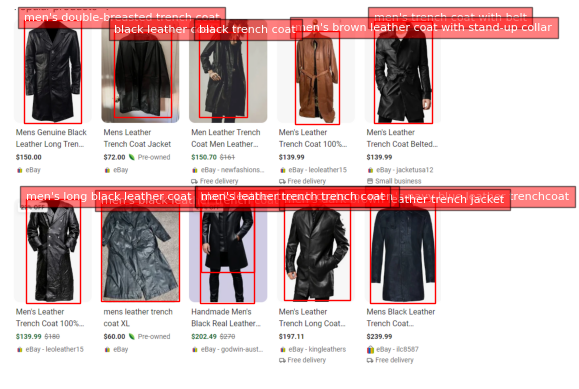

{'<DENSE_REGION_CAPTION>': {'bboxes': [[185.45050048828125, 397.0465087890625, 344.9114990234375, 596.89453125], [736.9564819335938, 389.47650146484375, 870.8684692382812, 599.9225463867188], [561.6375122070312, 395.5325012207031, 695.5494995117188, 594.62353515625], [27.75149917602539, 21.574501037597656, 145.8054962158203, 232.7775115966797], [744.885498046875, 22.331501007080078, 862.939453125, 232.0205078125], [32.156497955322266, 388.7195129394531, 143.16249084472656, 599.9225463867188], [388.96148681640625, 387.9625244140625, 499.08648681640625, 601.4365234375], [212.76148986816406, 45.798500061035156, 329.9344787597656, 219.90850830078125], [583.6624755859375, 43.52750015258789, 672.6434936523438, 233.53451538085938], [387.1994934082031, 46.55550003051758, 484.1094970703125, 220.66551208496094], [389.8424987792969, 387.9625244140625, 499.08648681640625, 536.3345336914062]], 'labels': ["men's black leather trench coat", "men's navy blue leather trenchcoat", "men's dark brown leat

In [27]:
results = run_example(image, task_prompt = '<DENSE_REGION_CAPTION>')
draw_bbox(image, results['<DENSE_REGION_CAPTION>'])
print(results)

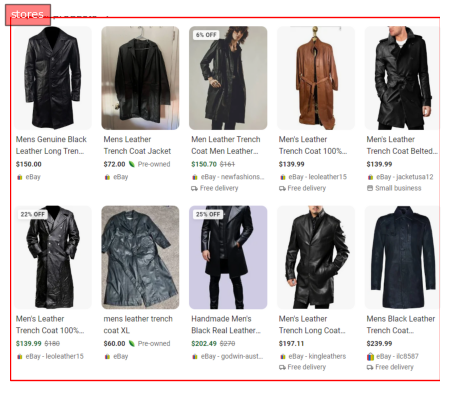

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[0.4404999911785126, 1.1355000734329224, 879.678466796875, 744.509521484375]], 'labels': ['stores']}}


In [31]:
results = run_example(image,task_prompt= '<CAPTION_TO_PHRASE_GROUNDING>', text_input="desciptions. images. prices. stores.")
draw_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])
print(results)

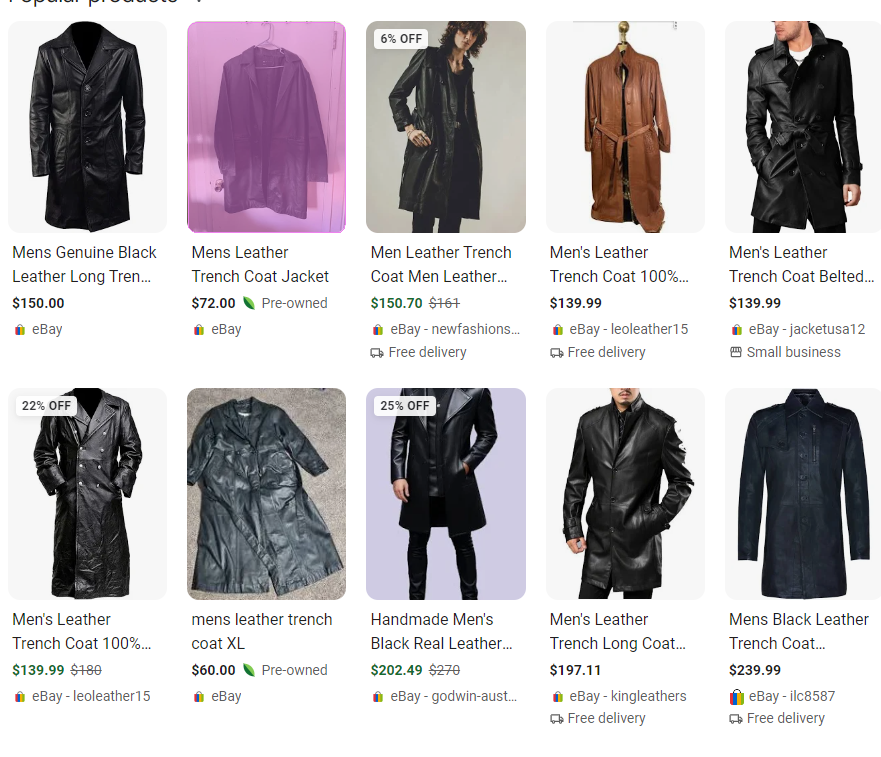

In [29]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(image, task_prompt, text_input="character")
output_image = copy.deepcopy(image)
draw_polygons(output_image, results[task_prompt])

In [32]:
task_prompt = '<OCR>'
run_example(image,task_prompt)

{'<OCR>': "Popular products -6% OFFMens Genuine BlackMens LeatherMen Leather Men's LeatherMen's LeatherLeather Long Tren ...Trench Coat JacketCoat Men Leather ...Trench Coat 100% ...Trenches Coat Belted ...$150.00$72.00Pre-owned$150,70 $161$139.99$139,99$199.99ebayebay - newfashions ...eBay - leoleather15ebay-jacketusa12eBayFree deliveryFree deliverySmall business22% OFF25% OFFMen's Leathermens leather trenchHandmade Men'sMen's leatherMens Black LeatherMens LeatherMen's Black LeatherFrench Coat 100%.coat XLBlack Real Leather ..Trench Long Coat ...French Coat ...$199,99 $189$60.00 Pre-owned $202.49 $270$197.11$239.99eBay-leoleather152 eBayebay eBay - godwin-aust ... eBay-kingleathersEbay - ilc8587Free deliveryC Free delivery"}

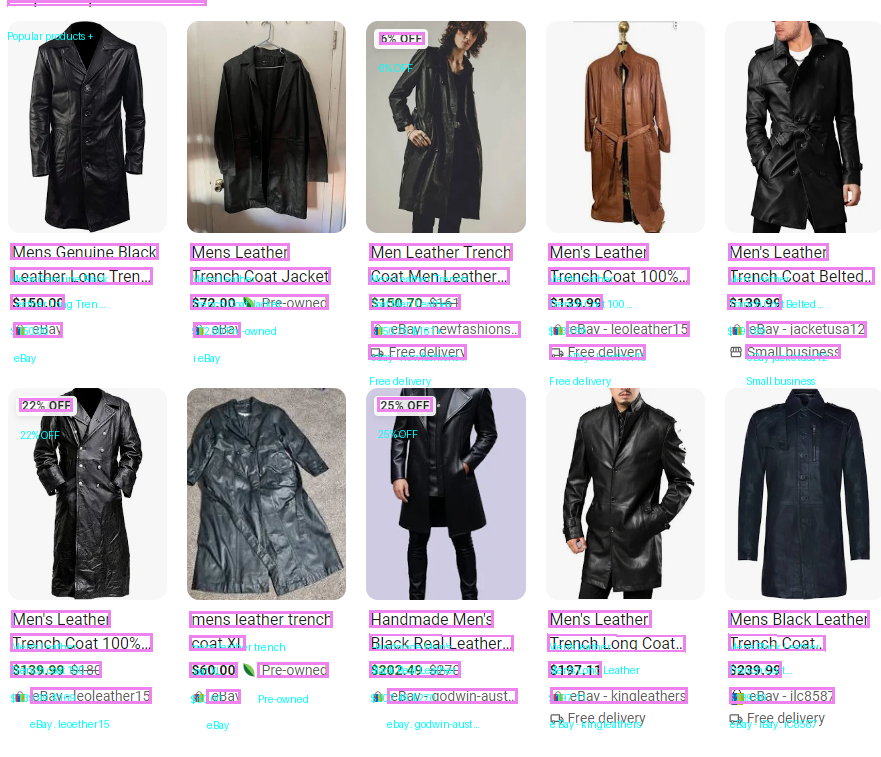

{'<OCR_WITH_REGION>': {'quad_boxes': [[7.488499641418457, 0.3785000145435333, 206.59449768066406, 0.3785000145435333, 206.59449768066406, 5.677500247955322, 7.488499641418457, 6.434500217437744], [379.2704772949219, 32.17250061035156, 424.20147705078125, 32.17250061035156, 424.20147705078125, 44.28450012207031, 379.2704772949219, 44.28450012207031], [10.131500244140625, 243.37550354003906, 158.13949584960938, 243.37550354003906, 158.13949584960938, 259.27252197265625, 10.131500244140625, 259.27252197265625], [190.7364959716797, 243.37550354003906, 289.40850830078125, 243.37550354003906, 289.40850830078125, 260.0295104980469, 190.7364959716797, 260.0295104980469], [369.5794982910156, 243.37550354003906, 512.301513671875, 243.37550354003906, 512.301513671875, 260.0295104980469, 369.5794982910156, 260.0295104980469], [548.4224853515625, 243.37550354003906, 648.8565063476562, 243.37550354003906, 648.8565063476562, 260.0295104980469, 548.4224853515625, 260.0295104980469], [728.146484375, 24

In [33]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(image,task_prompt)
output_image = copy.deepcopy(image)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])
print(results)